In [2]:
#This is checking one random file structure and header
import os
from astropy.io import fits
import matplotlib.pyplot as plt


In [3]:
#this dataset is level 3c data, the calibrated resampled iof end product
name = '/Volumes/BLUE/spectral_analysis.orex2/aaatmp/b/20210407T033051S512_ovr_scil3c_calv2.fits'
data = fits.open(name)
data.info()

#save wavelength once for all
wav = data[1].data

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/BLUE/spectral_analysis.orex2/aaatmp/b/20210407T033051S512_ovr_scil3c_calv2.fits'

In [6]:
#data[0].header

In [7]:
print(data[0].data)

[[ 0.04035722  0.05430858  0.04521629 ... -0.30075276 -0.31190126
  -0.32364401]]


(0.02, 0.04)

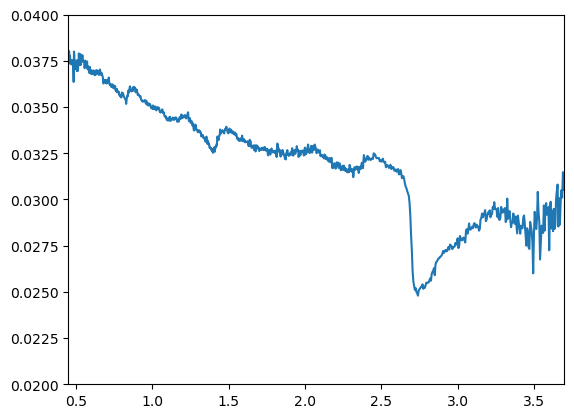

In [8]:
plt.plot(data[1].data,data[0].data[0,:])
plt.xlim(0.45, 3.7)
plt.ylim(0.02, 0.04)

In [9]:
#############

header_info = {key: val for key, val in data[0].header.items()}
print(header_info)

{'SIMPLE': True, 'BITPIX': -64, 'NAXIS': 2, 'NAXIS1': 1393, 'NAXIS2': 1, 'EXTEND': True, 'COMMENT': "  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H", 'DATE_OBS': '2021-04-07T03:30:51.367', 'MIDOBS': '2021-04-07T03:30:51.512', 'EXPTIME': 910.2, 'EXPOSEC': 0.9102, 'ET': 671038320.697593, 'MID_SCLK': '3/0671038177.29157', 'BS_FLAG': 1, 'FOV_FLAG': 1, 'BS_ANGLE': 3.28898020677068, 'LAT': 56.9451515081376, 'LON': 283.875039661132, 'RANGE': 3778.9809686389, 'BS_X': 31.0312772164494, 'BS_Y': -125.626236839658, 'BS_Z': 198.844698561129, 'INCIDANG': 46.3256543271714, 'EMISSANG': 58.0565119969337, 'PHASEANG': 12.3899751824053, 'IN100VEC': 53.4038466770275, 'EM100VEC': 63.9393300672637, 'IN100MU0': 54.1880920022068, 'EM100MU': 64.4623363844269, 'IN100ANG': 53.8122082327379, 'EM100ANG': 64.1781429709516, 'FILL_FAC': 1, 'SMJAX': 28.6722349226465, 'SMNAX': 15.1698222336583, 'SUN_RNG': 148904585.128483, 'TARGRNG': 3.86908150138535, 'BORE_RA': 0.562683594759018, 'BORE_DEC': -1

#太大的文件太小的内存，这段不好用，会打开太多文件死机 不要用
import os
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import numpy as np

# Define the root directory
root_dir = '/Volumes/BLUE/spectral_analysis.orex2/data_vnir_resampled_spectra-l3a'

# Prepare a list to store header data
header_data = []

# Define the header fields you want to extract
header_fields = [
    "DATE_OBS", "MIDOBS", "EXPTIME", "EXPOSEC", "ET", "MID_SCLK", 
    "BS_FLAG", "FOV_FLAG", "BS_ANGLE", "LAT", "LON", "RANGE", 
    "BS_X", "BS_Y", "BS_Z", "INCIDANG", "EMISSANG", "PHASEANG", 
    "IN100VEC", "EM100VEC", "IN100MU0", "EM100MU", "IN100ANG", 
    "EM100ANG", "FILL_FAC", "SMJAX", "SMNAX", "SUN_RNG", "TARGRNG", 
    "BORE_RA", "BORE_DEC", "BENNURA", "BENNUDEC", "BENNURDT", 
    "BENNURDQ", "META_KER", "SOLAZIM", "SCAZIM", "SNLST"
]



# Prepare lists for storing data and headers
combined_spectra = []
wavelength = None  # Initialize to store wavelength data from the first file

# Walk through all subfolders to find .fits files
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.fits'):
            file_path = os.path.join(subdir, file)
            
            # Open the fits file and read headers
            with fits.open(file_path) as hdul:
                # Read the PRIMARY header
                header = hdul[0].header
                
                # Check FILL_FAC and PHASEANG conditions
                fill_fac = header.get("FILL_FAC", 0)
                phaseang = header.get("PHASEANG", 0)
                
                if fill_fac != 1 or (isinstance(phaseang, (int, float)) and phaseang > 75):
                    # Skip this file if it doesn't meet the conditions
                    continue

                # Extract spectra data
                spectra_data = hdul[0].data[0, :]
                
                # Extract wavelength only once from the first file
                if wavelength is None:
                    wavelength = hdul[1].data  # Assuming this is stored in the second HDU
                
                # Append spectral data to the list
                combined_spectra.append(spectra_data)
                
                # Prepare a dictionary for this file's header data
                file_header_data = {"Filename": file}  # Start with the filename
                for field in header_fields:
                    # Get the value before the "/" if it exists, otherwise use the full value
                    value = header.get(field, 'N/A')
                    file_header_data[field] = str(value).split('/')[0].strip() if value != 'N/A' else 'N/A'
                
                # Append this file's header data to the list
                header_data.append(file_header_data)

# Stack all spectra into a NumPy array to maintain 1393-length rows
spectra_array = np.array(combined_spectra)

# Save combined spectra and wavelengths to a single FITS file
combined_fits = fits.HDUList([fits.PrimaryHDU(spectra_array), fits.ImageHDU(wavelength, name="WAVELENGTH")])
combined_fits.writeto('/Volumes/BLUE/spectral_analysis.orex2/data_vnir_resampled_spectra-l3a/combined_spectra.fits', overwrite=True)
print("Combined fits saved successfully.")
# Convert header data to a DataFrame and save to CSV
header_df = pd.DataFrame(header_data, columns=["Filename"] + header_fields)
header_df.to_csv('/Volumes/BLUE/spectral_analysis.orex2/data_vnir_resampled_spectra-l3a/headers_combined.csv', index=False)

print("Header CSV file saved successfully.")


In [13]:

#这是优化后的版本，6GB数据大概需要19小时！！（在移动硬盘上跑的话）
import os
import pandas as pd
from astropy.io import fits
import csv

# Define the root directory    
root_dir = '/Volumes/BLUE/spectral_analysis.orex2/data_vnir_iof_spectra-l3c'

# Define the output CSV file
output_csv_path = '/Volumes/BLUE/spectral_analysis.orex2/data_vnir_iof_spectra-l3c/headers_spectra_combined.csv'

# Define the header fields to extract
header_fields = [
    "DATE_OBS", "MIDOBS", "EXPTIME", "EXPOSEC", "ET", "MID_SCLK", 
    "BS_FLAG", "FOV_FLAG", "BS_ANGLE", "LAT", "LON", "RANGE", 
    "BS_X", "BS_Y", "BS_Z", "INCIDANG", "EMISSANG", "PHASEANG", 
    "IN100VEC", "EM100VEC", "IN100MU0", "EM100MU", "IN100ANG", 
    "EM100ANG", "FILL_FAC", "SMJAX", "SMNAX", "SUN_RNG", "TARGRNG", 
    "BORE_RA", "BORE_DEC", "BENNURA", "BENNUDEC", "BENNURDT", 
    "BENNURDQ", "META_KER", "SOLAZIM", "SCAZIM", "SNLST"
]

# Initialize the CSV file with headers
with open(output_csv_path, 'w', newline='') as csvfile:
    # Placeholder for wavelength data
    wavelength = None

    # First, set up the CSV writer
    csv_writer = None

    # Walk through all subfolders to find .fits files
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.fits'):
                file_path = os.path.join(subdir, file)

                # Open the fits file and read headers and data selectively
                with fits.open(file_path) as hdul:
                    header = hdul[0].header
                    
                    # Check FILL_FAC and PHASEANG conditions
                    fill_fac = header.get("FILL_FAC", 0)
                    iang = header.get("INCIDANG", 0)
                    eang = header.get("EMISSANG", 0)
                    if fill_fac != 1 or (isinstance(iang, (int, float)) and iang > 70) or (isinstance(eang, (int, float)) and eang > 70):
                        # Skip this file if it doesn't meet the conditions
                        continue

                    # Extract spectra data
                    spectra_data = hdul[0].data[0, :]  # Assume primary HDU has the spectral data

                    # Extract wavelength data only once
                    if wavelength is None:
                        wavelength = hdul[1].data  # Assume second HDU contains wavelength

                        # Dynamically set up the CSV header row
                        wavelength_headers = [f"Wavelength_{i+1}" for i in range(len(wavelength))]
                        csv_writer = csv.DictWriter(
                            csvfile,
                            fieldnames=["Filename"] + header_fields + wavelength_headers
                        )
                        csv_writer.writeheader()

                    # Prepare a dictionary for this file's header data
                    row_data = {"Filename": file}  # Start with the filename
                    for field in header_fields:
                        # Get the value before the "/" if it exists, otherwise use the full value
                        value = header.get(field, 'N/A')
                        row_data[field] = str(value).split('/')[0].strip() if value != 'N/A' else 'N/A'

                    # Add spectral data, with each wavelength as a separate column
                    for i, value in enumerate(spectra_data):
                        row_data[f"Wavelength_{i+1}"] = value

                    # Write the row directly to CSV
                    csv_writer.writerow(row_data)

print("Headers and spectra data saved to CSV successfully.")





Headers and spectra data saved to CSV successfully.


In [10]:
#checking combine results


In [1]:
#########  Start from this！ ####################
###load 所有数据，注意，这里面也包括了EGA和不可用的date 如 2019.03。14.



import pandas as pd
import numpy as np

# CSV文件路径
csv_path = '/Volumes/BLUE/spectral_analysis.orex2/data_vnir_iof_spectra-l3c/headers_spectra_combined.csv'

# 定义元数据列和光谱列
metadata_columns = [
    "Filename", "DATE_OBS", "MID_SCLK", "LAT", "LON", "RANGE", 
    "BS_X", "BS_Y", "BS_Z", "INCIDANG", "EMISSANG", "PHASEANG", 
    "FILL_FAC", "SMJAX", "SMNAX", "SUN_RNG", "TARGRNG", "BORE_RA", "BORE_DEC"
]
num_wavelengths = 1393
spectral_columns = [f"Wavelength_{i+1}" for i in range(num_wavelengths)]

# 用于存储元数据和光谱数据的表
metadata_table = []
spectral_data = np.zeros((num_wavelengths, 0), dtype=np.float32)  # 设置浮点数数据类型

# 定义分块大小
chunk_size = 5000

# 分块读取文件
for chunk in pd.read_csv(csv_path, chunksize=chunk_size, usecols=metadata_columns + spectral_columns, dtype={col: 'float32' for col in spectral_columns}):
    # 提取元数据并处理日期格式
    metadata_chunk = chunk[metadata_columns].copy()
    
    # 将DATE_OBS字段拆分为date和time，均保存为字符串
    metadata_chunk['date'] = metadata_chunk['DATE_OBS'].apply(lambda x: x[:10].replace('-', ''))
    metadata_chunk['time'] = metadata_chunk['DATE_OBS'].apply(lambda x: x[11:19].replace(':', ''))
    
    # 重命名MID_SCLK为sclk，保留为字符串
    metadata_chunk['sclk'] = metadata_chunk['MID_SCLK'].astype(str)
    metadata_chunk = metadata_chunk.drop(columns=['DATE_OBS', 'MID_SCLK'])
    
    # 将处理后的元数据添加到metadata_table中
    metadata_table.extend(metadata_chunk.values.tolist())
    
    # 提取光谱数据列并按列堆叠到spectral_data中
    spectral_chunk = chunk[spectral_columns].values.T
    spectral_data = np.hstack((spectral_data, spectral_chunk))

# 将元数据转换为DataFrame并命名列
metadata_table = pd.DataFrame(metadata_table, columns=[col for col in metadata_columns if col not in ['DATE_OBS', 'MID_SCLK']] + ['date', 'time', 'sclk'])

# 按日期统计每个date的条目数、最大最小统计信息，以及每日平均targrng
date_stats = metadata_table.groupby('date').agg(
    count=('date', 'size'),
    min_inc=('INCIDANG', 'min'),
    max_inc=('INCIDANG', 'max'),
    min_emi=('EMISSANG', 'min'),
    max_emi=('EMISSANG', 'max'),
    min_pha=('PHASEANG', 'min'),
    max_pha=('PHASEANG', 'max'),
    min_ran=('TARGRNG', 'min'),
    max_ran=('TARGRNG', 'max'),
    mean_range=('TARGRNG', 'mean')
).reset_index()

# 保存统计结果为CSV文件
output_path = '/Volumes/BLUE/spectral_analysis.orex2/data_vnir_iof_spectra-l3c/daily_stats.csv'
date_stats.to_csv(output_path, index=False)

# 输出结果
print("Metadata table shape:", metadata_table.shape)
print("Spectral data shape:", spectral_data.shape)
print("Date statistics saved to:", output_path)


Metadata table shape: (155956, 20)
Spectral data shape: (1393, 155956)
Date statistics saved to: /Volumes/BLUE/spectral_analysis.orex2/data_vnir_iof_spectra-l3c/daily_stats.csv


In [2]:
#检查每一天的i e a distribution

import matplotlib.pyplot as plt

def distribution(metadata_table):
    # Extract unique days of year from metadata
    doys = list(set(metadata_table['date']))  # Assuming 'date' is in YYYYMMDD format
    
    for doy in doys:
        # Filter data for the specific day
        dff = metadata_table[metadata_table['date'] == doy]
        dff = dff[dff['LAT'] >= -90]  # Filter latitude if needed
        
        # Extract geometry and spatial columns
        inc = dff['INCIDANG']
        emi = dff['EMISSANG']
        alp = dff['PHASEANG']
        lat = dff['LAT']
        
        # Plot setup
        plt.rcParams['figure.figsize'] = [10, 5]
        plt.plot(inc, lat, label='Incidence', ms=2, marker='.', color='gray', linestyle='None')
        plt.plot(emi, lat, label='Emission', ms=2, marker='.', color='#e62a76', linestyle='None')
        plt.plot(alp, lat, label='Phase', ms=2, marker='.', color='#fbb901', linestyle='None')
        
        # Label and title setup
        plt.xlabel('i/e/α angles (Deg)')
        plt.ylabel('Latitude (Deg)')
        plt.legend(loc='best')
        plt.title(f'i/e/α distribution for date {doy}')
        
        # Save plot to specified directory
        plotname = f'/Volumes/BLUE/spectral_analysis.orex2/data_vnir_iof_spectra-l3c/summary/iea_distribution_{doy}.png'
        plt.savefig(plotname)
        plt.close()

# Usage with your metadata_table
distribution(metadata_table)


In [3]:
#检查每一天数据的空间分布

import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos

def boreposi(metadata_table):
    # Filter each unique date in the metadata_table
    dates = metadata_table['date'].unique()
    
    for doy in dates:
        # Filter data for specific day and apply additional filters
        df = metadata_table[metadata_table['date'] == doy]

        
        # Extract columns
        lon = df['LON']
        lat = df['LAT']
        phase_ang = df['PHASEANG']  # Phase angle for color bar
        ran = df['TARGRNG']  # Assuming 'TARGRNG' is the correct column for range

        
        # Latitude and angular transformations
        lat_arc = [lati / 180 * pi for lati in lat]
        coslat = np.array([cos(lati) for lati in lat_arc])
        ran = np.array(ran)
        scale = 1.7**2 * ran**2 / coslat**2
        
        # Calculate disk function
        inc_arc = np.radians(df['INCIDANG'])
        emi_arc = np.radians(df['EMISSANG'])
        cosi = np.cos(inc_arc)
        cose = np.cos(emi_arc)
        disk = cosi / (cosi + cose)
        dr = np.array(ran) / disk
        
        # Scatter plot setup for current date
        plt.figure(figsize=(10, 5))
        plt.scatter(lon, lat, s=2, c=phase_ang, cmap='jet')
        plt.colorbar(label='Phase Angle (Degrees)')
        plt.xlabel('Longitude (Degrees)')
        plt.ylabel('Latitude (Degrees)')
        plt.grid(True)
        plt.title(f'Latitude-Longitude Scatter Map for Date {doy}')
        
        # Save plot for each date
        plotname = f'/Volumes/BLUE/spectral_analysis.orex2/data_vnir_iof_spectra-l3c/summary/position_{doy}.png'
        plt.savefig(plotname)
        plt.close()

# Usage with your metadata_table
boreposi(metadata_table)


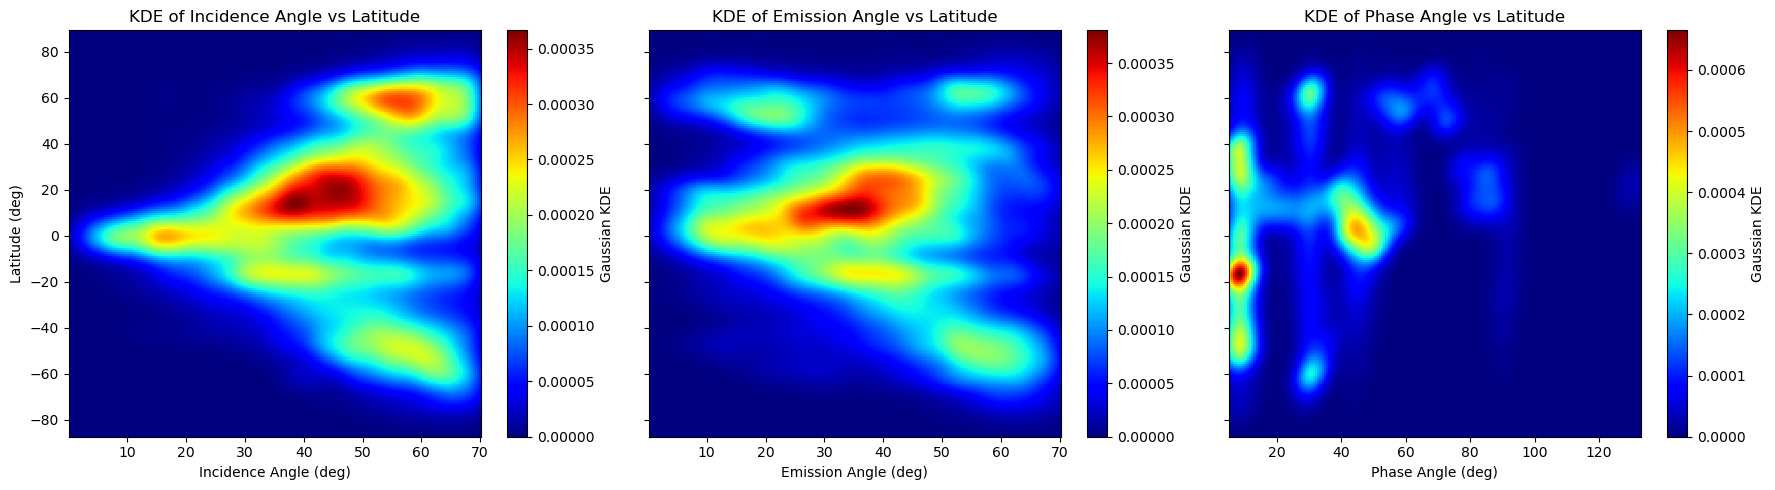

In [4]:
#SPDIF数据情况和filtering
#这是合并所有日期的，所以要先去除数据里面三个date的[20170922, 20170925, 20190314]点， 其中20190314这一天是因为仪器过热

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def plot_kde(metadata_table, spectral_data):
    # Filter out specified dates
    dates_to_exclude = [20170922, 20170925, 20190314]
    metadata_table_filtered = metadata_table[~metadata_table['date'].isin(dates_to_exclude)]
    
    # Get the indices of the filtered rows to apply to spectral_data
    indices = metadata_table_filtered.index
    spectral_data_filtered = spectral_data[:, indices]  # Filtered spectral data

    # Define columns for each plot
    inc = metadata_table_filtered['INCIDANG']   # Incidence angle
    emi = metadata_table_filtered['EMISSANG']   # Emission angle
    pha = metadata_table_filtered['PHASEANG']   # Phase angle
    lat = metadata_table_filtered['LAT']        # Latitude (common y-axis)

    # Set up grid for KDE calculation
    nbins = 200
    
    # Calculate KDE for each plot
    def calculate_kde(x, y, nbins):
        k = gaussian_kde([x, y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        return xi, yi, zi

    # Prepare KDE for each angle
    xi_inc, yi_inc, zi_inc = calculate_kde(inc, lat, nbins)
    xi_emi, yi_emi, zi_emi = calculate_kde(emi, lat, nbins)
    xi_pha, yi_pha, zi_pha = calculate_kde(pha, lat, nbins)
    
    # Plot setup
    plt.rcParams['figure.figsize'] = [18, 5]
    fig, axes = plt.subplots(1, 3, sharey=True)
    
    # Incidence Angle Plot
    c1 = axes[0].pcolormesh(xi_inc, yi_inc, zi_inc.reshape(xi_inc.shape), cmap='jet')
    fig.colorbar(c1, ax=axes[0], label='Gaussian KDE')
    axes[0].set_xlabel('Incidence Angle (deg)')
    axes[0].set_ylabel('Latitude (deg)')
    axes[0].set_title('KDE of Incidence Angle vs Latitude')
    
    # Emission Angle Plot
    c2 = axes[1].pcolormesh(xi_emi, yi_emi, zi_emi.reshape(xi_emi.shape), cmap='jet')
    fig.colorbar(c2, ax=axes[1], label='Gaussian KDE')
    axes[1].set_xlabel('Emission Angle (deg)')
    axes[1].set_title('KDE of Emission Angle vs Latitude')
    
    # Phase Angle Plot
    c3 = axes[2].pcolormesh(xi_pha, yi_pha, zi_pha.reshape(xi_pha.shape), cmap='jet')
    fig.colorbar(c3, ax=axes[2], label='Gaussian KDE')
    axes[2].set_xlabel('Phase Angle (deg)')
    axes[2].set_title('KDE of Phase Angle vs Latitude')
    
    plt.tight_layout()
    plt.show()

# Usage with your metadata_table and spectral_data
plot_kde(metadata_table, spectral_data)


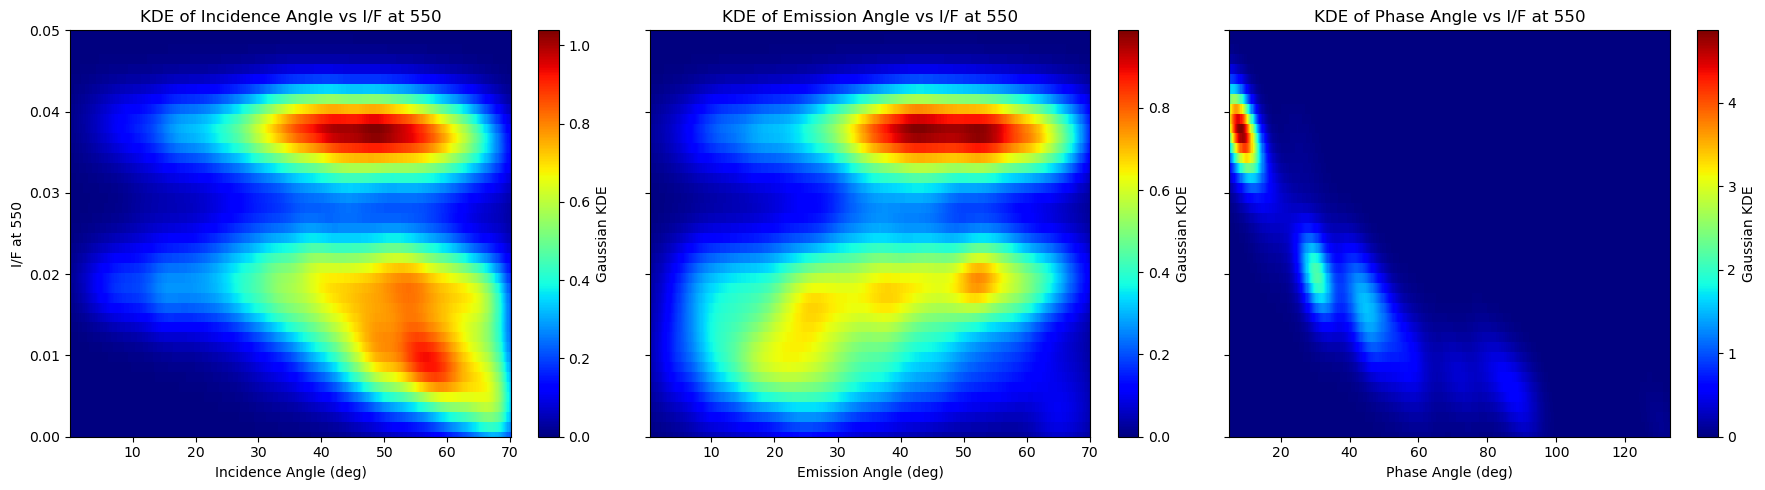

In [63]:
#同上，看整体数据分布，把LAT换成了I/F 550nm 波段
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def plot_kde_spectral(metadata_table, spectral_data):
    # Filter out specified dates
    dates_to_exclude = [20170922, 20170925, 20190314]
    metadata_table_filtered = metadata_table[~metadata_table['date'].isin(dates_to_exclude)]
    
    # Get the indices of the filtered rows to apply to spectral_data
    indices = metadata_table_filtered.index
    spectral79 = spectral_data[79, indices]  # Use the 550nm spectral band (Python index 79)

    # Define columns for each plot
    inc = metadata_table_filtered['INCIDANG']   # Incidence angle
    emi = metadata_table_filtered['EMISSANG']   # Emission angle
    pha = metadata_table_filtered['PHASEANG']   # Phase angle

    # Set up grid for KDE calculation
    nbins = 400
    
    # Calculate KDE for each plot
    def calculate_kde(x, y, nbins):
        k = gaussian_kde([x, y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        return xi, yi, zi

    # Prepare KDE for each angle
    xi_inc, yi_inc, zi_inc = calculate_kde(inc, spectral79, nbins)
    xi_emi, yi_emi, zi_emi = calculate_kde(emi, spectral79, nbins)
    xi_pha, yi_pha, zi_pha = calculate_kde(pha, spectral79, nbins)
    
    # Plot setup
    plt.rcParams['figure.figsize'] = [18, 5]
    fig, axes = plt.subplots(1, 3, sharey=True)
    
    # Incidence Angle Plot
    c1 = axes[0].pcolormesh(xi_inc, yi_inc, zi_inc.reshape(xi_inc.shape), cmap='jet')
    fig.colorbar(c1, ax=axes[0], label='Gaussian KDE')
    axes[0].set_xlabel('Incidence Angle (deg)')
    axes[0].set_ylabel('I/F at 550')
    axes[0].set_title('KDE of Incidence Angle vs I/F at 550')
    axes[0].set_ylim(0, 0.05)
    
    # Emission Angle Plot
    c2 = axes[1].pcolormesh(xi_emi, yi_emi, zi_emi.reshape(xi_emi.shape), cmap='jet')
    fig.colorbar(c2, ax=axes[1], label='Gaussian KDE')
    axes[1].set_xlabel('Emission Angle (deg)')
    axes[1].set_title('KDE of Emission Angle vs I/F at 550')
    axes[1].set_ylim(0, 0.05)
    
    # Phase Angle Plot
    c3 = axes[2].pcolormesh(xi_pha, yi_pha, zi_pha.reshape(xi_pha.shape), cmap='jet')
    fig.colorbar(c3, ax=axes[2], label='Gaussian KDE')
    axes[2].set_xlabel('Phase Angle (deg)')
    axes[2].set_title('KDE of Phase Angle vs I/F at 550')
    axes[2].set_ylim(0, 0.05)
    
    plt.tight_layout()
    plt.show()

# Usage with your metadata_table and spectral_data
plot_kde_spectral(metadata_table, spectral_data)


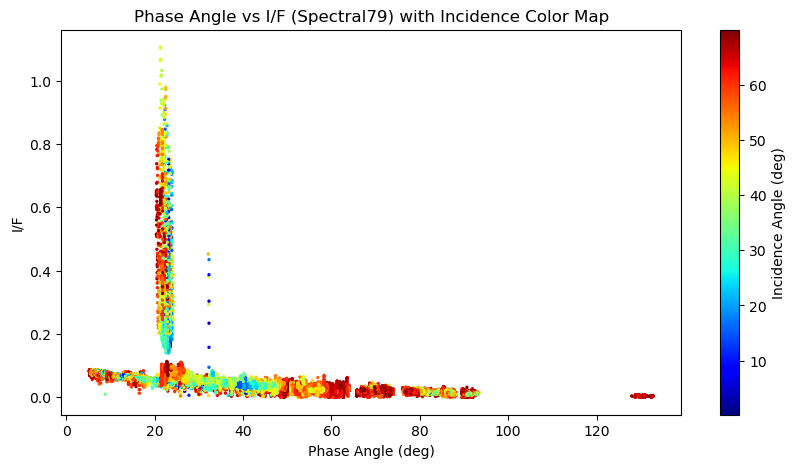

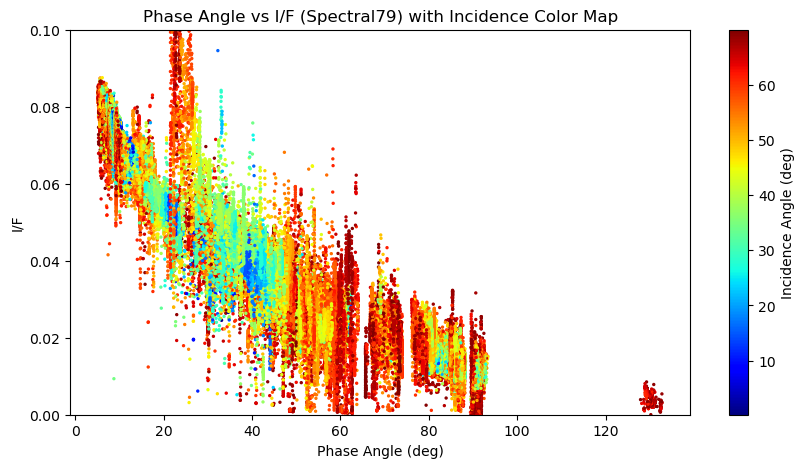

In [5]:
#这里是为了大致看一下所有数据点整体的phase curve

import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos

def plot_phafunc(metadata_table, spectral_data):
    # Filter the DataFrame as required
    
    # Filter out specified dates
    dates_to_exclude = [20170922, 20170925, 20190314]
    metadata_table_filtered = metadata_table[~metadata_table['date'].isin(dates_to_exclude)]
    
    # Get the indices of the filtered rows to apply to spectral_data
    indices = metadata_table_filtered.index
    spectral79 = spectral_data[79, indices]  # Use the 550nm spectral band (Python index 79)
    df = metadata_table_filtered
    # Extract relevant columns
    inc = df['INCIDANG']
    emi = df['EMISSANG']
    alp = df['PHASEANG']
    lon = df['LON']
    lat = df['LAT']


    # Filter spectral79 to match the length of df if needed
    if len(spectral79) != len(df):
        raise ValueError("Length of spectral79 does not match the number of rows in the filtered metadata table")

    # Convert angles to radians for cosine calculations
    inc_arc = np.radians(inc)
    emi_arc = np.radians(emi)
    cosi = np.cos(inc_arc)
    cose = np.cos(emi_arc)
    
    # Calculate disk function
    disk = cosi / (cosi + cose)
    dr = spectral79 / disk  # Use spectral79 instead of rr

    # Plot setup
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.scatter(alp, dr, s=2, c=inc, cmap='jet')  # Phase angle vs spectral79 with incidence color map
    plt.colorbar(label='Incidence Angle (deg)')
    plt.xlabel('Phase Angle (deg)')
    plt.ylabel('I/F')
    plt.title('Phase Angle vs I/F (Spectral79) with Incidence Color Map')
    plt.show()
    
    # Plot setup
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.scatter(alp, dr, s=2, c=inc, cmap='jet')  # Phase angle vs spectral79 with incidence color map
    plt.colorbar(label='Incidence Angle (deg)')
    plt.xlabel('Phase Angle (deg)')
    plt.ylabel('I/F')
    plt.ylim(0, 0.1)  # Set y-axis limit
    plt.title('Phase Angle vs I/F (Spectral79) with Incidence Color Map')
    plt.show()

# Usage with your metadata_table and spectral_data
plot_phafunc(metadata_table, spectral_data)


In [6]:
##画每一天的phase curve 查看数据质量

import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos

def phasecurvedaily(metadata_table, spectral_data):
    # Filter each unique date in the metadata_table
    dates = metadata_table['date'].unique()
    
    for doy in dates:
        # Filter data for specific day and apply additional filters
        df = metadata_table[metadata_table['date'] == doy]
        
        # Use the indices of the filtered metadata to get corresponding spectral data rows
        indices = df.index
        spectral79 = spectral_data[78, indices]  # 79th row, only for filtered indices

        # Check if lengths match (optional sanity check)
        if len(spectral79) != len(df):
            raise ValueError("Length of spectral79 does not match the number of rows in the filtered metadata table")

        # Extract relevant columns from filtered metadata
        inc = df['INCIDANG']
        emi = df['EMISSANG']
        alp = df['PHASEANG']
        lon = df['LON']
        lat = df['LAT']

        # Convert angles to radians for cosine calculations
        inc_arc = np.radians(inc)
        emi_arc = np.radians(emi)
        cosi = np.cos(inc_arc)
        cose = np.cos(emi_arc)
        
        # Calculate disk function
        disk = cosi / (cosi + cose)
        dr = spectral79 / disk  # Use spectral79 for I/F calculation

        # Plot setup
        plt.rcParams['figure.figsize'] = [10, 5]
        plt.scatter(alp, dr, s=2, c=inc, cmap='jet')  # Phase angle vs spectral79 with incidence color map
        plt.colorbar(label='Incidence Angle (deg)')
        plt.xlabel('Phase Angle (deg)')
        plt.ylabel('I/F')
        plt.title(f'Phase Angle vs I/F (Spectral79) on DOY {doy} with Incidence Color Map')

        # Save plot for each date
        plotname = f'/Volumes/BLUE/spectral_analysis.orex2/data_vnir_iof_spectra-l3c/summary/phaCurve_{doy}.png'
        plt.savefig(plotname)
        plt.close()

# Usage with your metadata_table and spectral_data
phasecurvedaily(metadata_table, spectral_data)



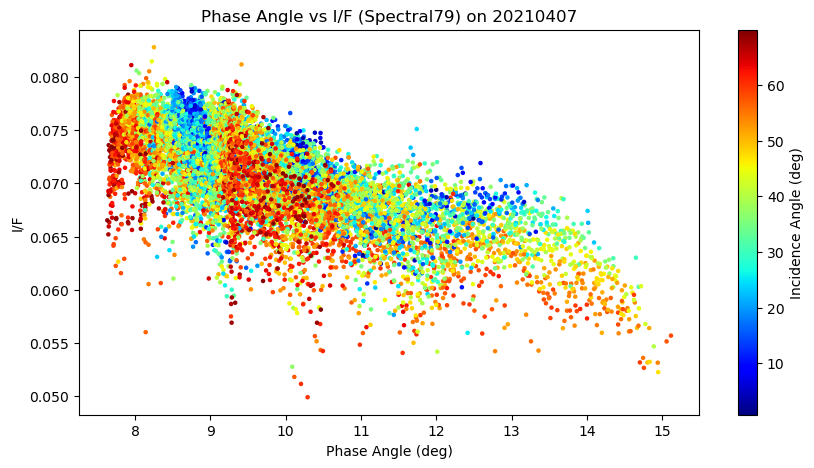

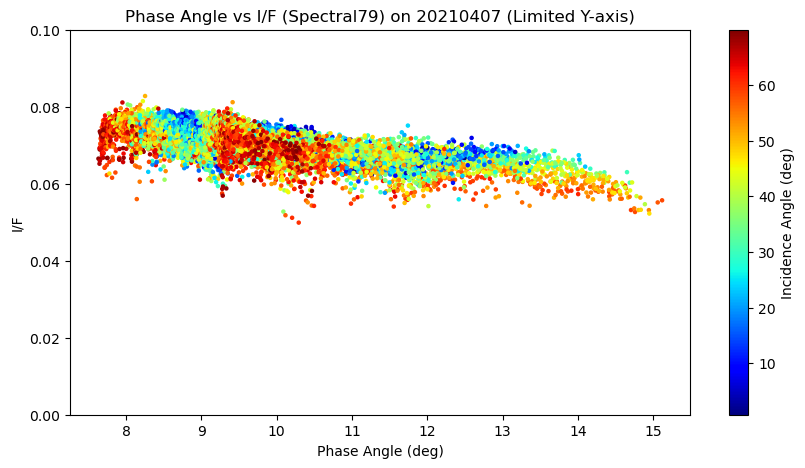

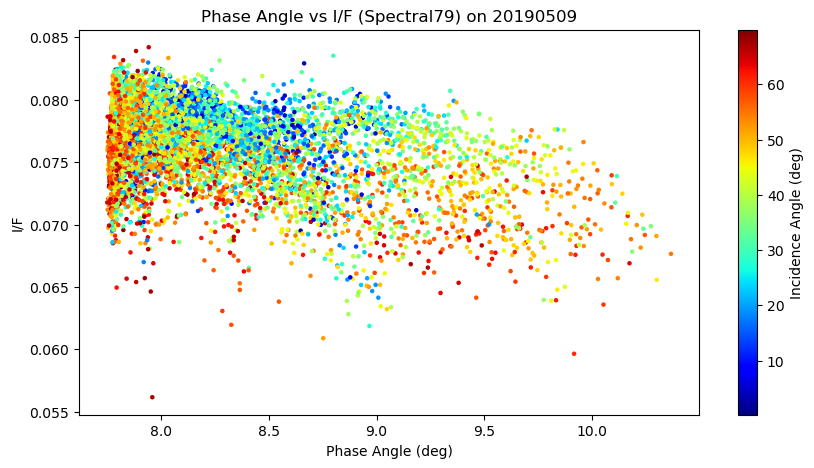

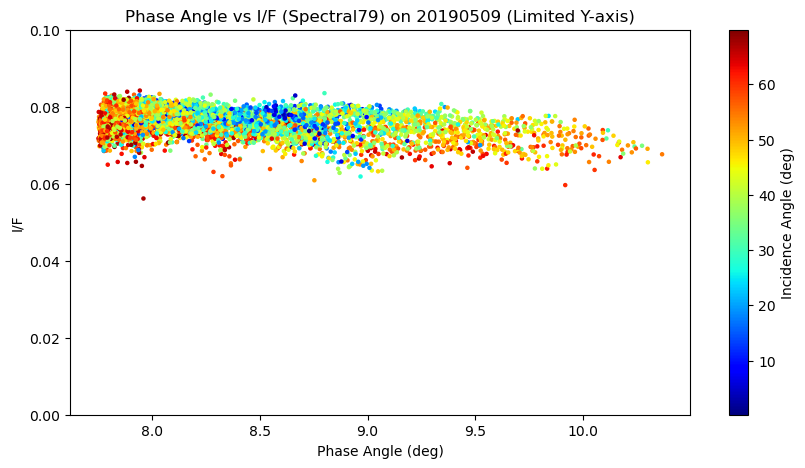

In [10]:
##plot指定日期的phase curve
import numpy as np
import matplotlib.pyplot as plt

def plot_phafunc_specific_date(metadata_table, spectral_data, specific_date):
    # Filter the DataFrame for the specific date
    metadata_table_filtered = metadata_table[metadata_table['date'] == specific_date]

    if metadata_table_filtered.empty:
        raise ValueError(f"No data found for the specified date: {specific_date}")

    # Get the indices of the filtered rows to apply to spectral_data
    indices = metadata_table_filtered.index
    spectral79 = spectral_data[79, indices]  # Use the 550nm spectral band (Python index 79)
    df = metadata_table_filtered

    # Extract relevant columns
    inc = df['INCIDANG']
    emi = df['EMISSANG']
    alp = df['PHASEANG']

    # Convert angles to radians for cosine calculations
    inc_arc = np.radians(inc)
    emi_arc = np.radians(emi)
    cosi = np.cos(inc_arc)
    cose = np.cos(emi_arc)

    # Calculate disk function
    disk = cosi / (cosi + cose)
    dr = spectral79 / disk

    # Plot setup
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.scatter(alp, dr, s=5, c=inc, cmap='jet')  # Phase angle vs spectral79 with incidence color map
    plt.colorbar(label='Incidence Angle (deg)')
    plt.xlabel('Phase Angle (deg)')
    plt.ylabel('I/F')
    plt.title(f'Phase Angle vs I/F (Spectral79) on {specific_date}')
    plt.show()

    # Additional plot with y-axis limit
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.scatter(alp, dr, s=5, c=inc, cmap='jet')
    plt.colorbar(label='Incidence Angle (deg)')
    plt.xlabel('Phase Angle (deg)')
    plt.ylabel('I/F')
    plt.ylim(0, 0.1)  # Set y-axis limit
    plt.title(f'Phase Angle vs I/F (Spectral79) on {specific_date} (Limited Y-axis)')
    plt.show()

# Example usage with your metadata_table, spectral_data, and a specific date
plot_phafunc_specific_date(metadata_table, spectral_data, '20210407')
plot_phafunc_specific_date(metadata_table, spectral_data, '20190509')

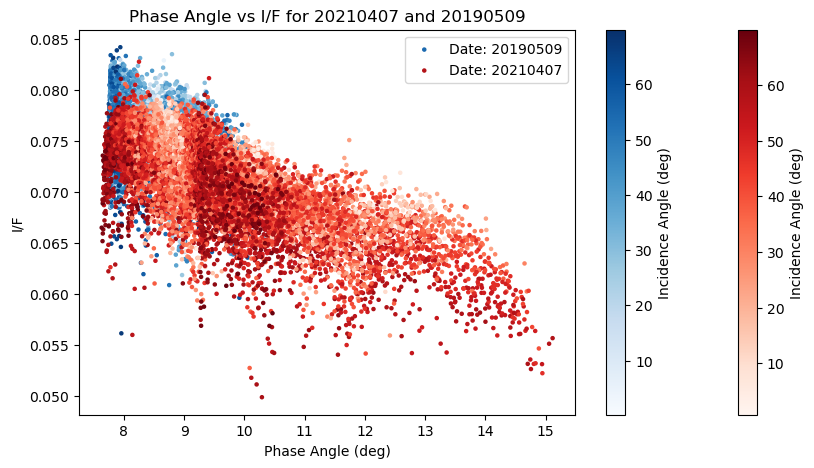

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_phafunc_combined(metadata_table, spectral_data, date1, date2):
    # Filter data for the two specific dates
    metadata_table_date1 = metadata_table[metadata_table['date'] == date1]
    metadata_table_date2 = metadata_table[metadata_table['date'] == date2]

    if metadata_table_date1.empty:
        raise ValueError(f"No data found for the specified date: {date1}")
    if metadata_table_date2.empty:
        raise ValueError(f"No data found for the specified date: {date2}")

    # Get the indices of the filtered rows for both dates
    indices_date1 = metadata_table_date1.index
    indices_date2 = metadata_table_date2.index

    spectral79_date1 = spectral_data[79, indices_date1]  # 550nm spectral band
    spectral79_date2 = spectral_data[79, indices_date2]

    # Extract relevant columns for both dates
    inc_date1 = metadata_table_date1['INCIDANG']
    emi_date1 = metadata_table_date1['EMISSANG']
    alp_date1 = metadata_table_date1['PHASEANG']

    inc_date2 = metadata_table_date2['INCIDANG']
    emi_date2 = metadata_table_date2['EMISSANG']
    alp_date2 = metadata_table_date2['PHASEANG']

    # Convert angles to radians for cosine calculations
    cosi_date1 = np.cos(np.radians(inc_date1))
    cose_date1 = np.cos(np.radians(emi_date1))
    disk_date1 = cosi_date1 / (cosi_date1 + cose_date1)
    dr_date1 = spectral79_date1 / disk_date1

    cosi_date2 = np.cos(np.radians(inc_date2))
    cose_date2 = np.cos(np.radians(emi_date2))
    disk_date2 = cosi_date2 / (cosi_date2 + cose_date2)
    dr_date2 = spectral79_date2 / disk_date2

    # Plot setup
    plt.rcParams['figure.figsize'] = [10, 5]

   
    # Plot data for date2 (light blue to dark blue)
    scatter2 = plt.scatter(alp_date2, dr_date2, s=5, c=inc_date2, cmap='Blues', label=f'Date: {date2}')
    # Plot data for date1 (pink to red)
    scatter1 = plt.scatter(alp_date1, dr_date1, s=5, c=inc_date1, cmap='Reds', label=f'Date: {date1}')
    
    # Add red color bar
    cbar1 = plt.colorbar(scatter1, label='Incidence Angle (deg)', orientation='vertical')
    cbar2 = plt.colorbar(scatter2, label='Incidence Angle (deg)', orientation='vertical')

    # Set axis limits
    #plt.xlim(7.6, 10)
    #plt.ylim(0.064, 0.083)

    # Set labels and title
    plt.xlabel('Phase Angle (deg)')
    plt.ylabel('I/F')
    plt.title(f'Phase Angle vs I/F for {date1} and {date2}')
    plt.legend()
    plt.show()

# Example usage with your metadata_table, spectral_data, and specific dates
plot_phafunc_combined(metadata_table, spectral_data, '20210407', '20190509')


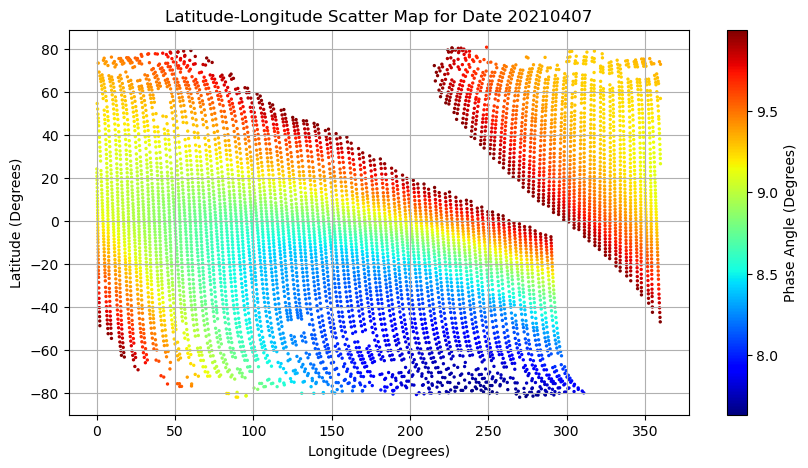

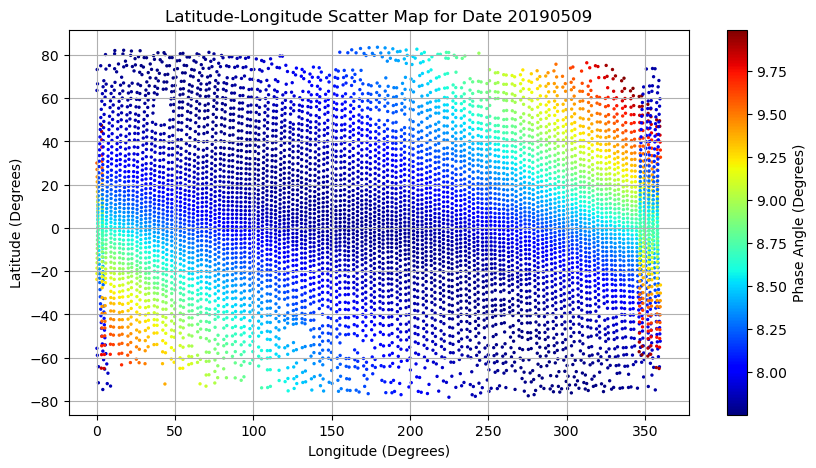

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos

def plot_position(metadata_table, specific_date, lat_exclude=None, lon_exclude=None, phase_angle_range=None):
    """
    Plot the spatial distribution (longitude and latitude) of data for a specified date,
    excluding points within the specified latitude and longitude ranges.

    Parameters:
    - metadata_table: pandas DataFrame containing metadata.
    - specific_date: str, the date to filter and plot (e.g., '20210407').
    - lat_exclude: tuple, optional, range of latitude to exclude (min_lat, max_lat).
    - lon_exclude: tuple, optional, range of longitude to exclude (min_lon, max_lon).
    - phase_angle_range: tuple, optional, range of phase angles to include (min_angle, max_angle).
    """
    # Filter for the specific date
    df = metadata_table[metadata_table['date'] == specific_date]

    if df.empty:
        raise ValueError(f"No data found for the specified date: {specific_date}")

    # Exclude points within the lat-lon range
    if lat_exclude:
        df = df[~((df['LAT'] >= lat_exclude[0]) & (df['LAT'] <= lat_exclude[1])&(df['LON'] >= lon_exclude[0]) & (df['LON'] <= lon_exclude[1]))]

   

    # Apply phase angle range filter
    if phase_angle_range:
        df = df[(df['PHASEANG'] >= phase_angle_range[0]) & (df['PHASEANG'] <= phase_angle_range[1])]

    if df.empty:
        raise ValueError("No data remains after applying filters.")

    # Extract columns
    lon = df['LON']
    lat = df['LAT']
    phase_ang = df['PHASEANG']  # Phase angle for color bar

    # Plot setup
    plt.figure(figsize=(10, 5))
    plt.scatter(lon, lat, s=2, c=phase_ang, cmap='jet')
    plt.colorbar(label='Phase Angle (Degrees)')
    plt.xlabel('Longitude (Degrees)')
    plt.ylabel('Latitude (Degrees)')
    plt.grid(True)
    plt.title(f'Latitude-Longitude Scatter Map for Date {specific_date}')
    plt.show()
    

# Example usage with metadata_table
plot_position(metadata_table, '20210407', lat_exclude=(51, 61), lon_exclude=(37, 47), phase_angle_range=(0, 10))
plot_position(metadata_table, '20190509', lat_exclude=(51, 61), lon_exclude=(37, 47), phase_angle_range=(0, 10))

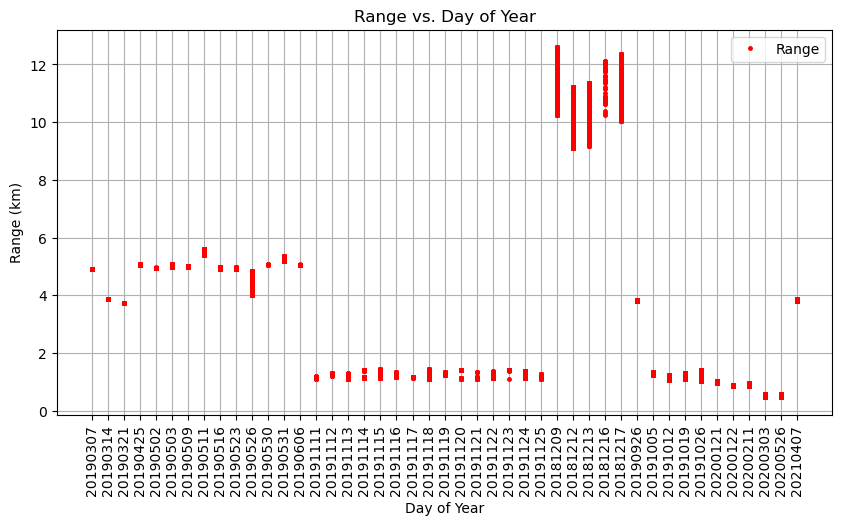

In [65]:
import matplotlib.pyplot as plt

def doy_range(metadata_table):
    # Filter data where fill factor is 1
    df = metadata_table[metadata_table['TARGRNG'] < 20]
    
    # Extract relevant columns
    doy = df['date']          # Day of year or date column in metadata_table
    rang = df['TARGRNG']       # Assuming 'TARGRNG' is the column for range
    
    # Plot setup
    plt.figure(figsize=(10, 5))
    plt.plot(doy, rang, 'r.', label='Range', ms=5)
    plt.xlabel('Day of Year')
    plt.xticks(rotation=90)    # Rotate x-axis labels by 45 degrees
    plt.ylabel('Range (km)')  # Adjust units if known
    plt.legend(loc='best')
    plt.title('Range vs. Day of Year')
    plt.grid()
    plt.show()

# Usage with your metadata_table
doy_range(metadata_table)


In [68]:
#filter with date and range...

def meta_filter(metadata_table, spectral_data, 
                max_range=None, 
                specific_date=None, 
                exclude_dates=None):
    """
    Filters metadata_table and spectral_data based on specified conditions.
    
    Parameters:
    - metadata_table: DataFrame containing metadata
    - spectral_data: 2D array with spectral data where rows are bands and columns are samples
    - max_range: float, optional - maximum value for TARGRNG to include
    - specific_date: int, optional - specific date (YYYYMMDD) to include
    - exclude_dates: list of ints, optional - list of dates (YYYYMMDD) to exclude
   
    
    Returns:
    - metadata_table_filtered: DataFrame with applied filters
   
    """
    
    # Apply max_range filter if specified
    if max_range is not None:
        metadata_table = metadata_table[metadata_table['TARGRNG'] < max_range]
    
    # Apply specific_date filter if specified
    if specific_date is not None:
        metadata_table = metadata_table[metadata_table['date'] == specific_date]
    
    # Exclude specified dates if provided
    if exclude_dates is not None:
        metadata_table = metadata_table[~metadata_table['date'].isin(exclude_dates)]
    
    # Get the indices of the filtered metadata_table to apply to spectral_data
    indices = metadata_table.index
    spectral_band_filtered = spectral_data[:, indices]  # Extract matching indices
    
    return metadata_table, spectral_band_filtered

# Usage example



In [70]:
filtered_metadata, filtered_spectral = meta_filter(
    metadata_table, 
    spectral_data, 
    max_range=20, 
    exclude_dates=[20170922, 20170925, 20190314])

In [12]:
#extracts specific rows from metadata_table and spectral_data based on your specified 
#criteria (date, SCLK, latitude, or longitude), then plots the spectral data with the 
#band index on the x-axis and the spectral values on the y-axis

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def plot_spectra(metadata_table, spectral_data, date=None, sclk=None, lat=None, lon=None):
    """
    Extracts and plots spectral data based on specified metadata criteria.
    
    Parameters:
    - metadata_table: DataFrame containing metadata
    - spectral_data: 2D array with spectral data where rows are bands and columns are samples
    - date: tuple(int, int) or int, optional - (min_date, max_date) range or specific date to filter
    - sclk: tuple(float, float) or float, optional - (min_sclk, max_sclk) range or specific SCLK to filter
    - lat: tuple(float, float) or float, optional - (min_lat, max_lat) range or specific latitude to filter
    - lon: tuple(float, float) or float, optional - (min_lon, max_lon) range or specific longitude to filter
    """

    ### Filter begin ###########################
    #max_range = None, 
    #specific_date = None, 
    #exclude_dates = None
    #max_range = 50, 
    exclude_dates = [20170922, 20170925, 20190314]
    
    # # Apply max_range filter if specified
    # if max_range is not None:
    #     metadata_table = metadata_table[metadata_table['TARGRNG'] < max_range]    
    # # Apply specific_date filter if specified
    # if specific_date is not None:
    #     metadata_table = metadata_table[metadata_table['date'] == specific_date] 
    # Exclude specified dates if provided
    if exclude_dates is not None:
        metadata_table = metadata_table[~metadata_table['date'].isin(exclude_dates)]
    # # Get the indices of the filtered metadata_table to apply to spectral_data
    # ind = metadata_table.index
    # spectral_band_filtered = spectral_data[:, ind]  # Extract matching indices
    ### Filter end #############################  
    
    # Convert 'date' column to integer if needed
    if metadata_table['date'].dtype == 'object':
        metadata_table['date'] = metadata_table['date'].astype(int)
    
    # Apply filters based on provided criteria
    df = metadata_table
    
    # Date filter
    if date is not None:
        if isinstance(date, tuple):
            df = df[(df['date'] >= date[0]) & (df['date'] <= date[1])]
        else:
            df = df[df['date'] == date]
    
    # SCLK filter
    if sclk is not None:
        if isinstance(sclk, tuple):
            df = df[(df['sclk'] >= sclk[0]) & (df['sclk'] <= sclk[1])]
        else:
            df = df[df['sclk'] == sclk]
    
    # Latitude filter
    if lat is not None:
        if isinstance(lat, tuple):
            df = df[(df['LAT'] >= lat[0]) & (df['LAT'] <= lat[1])]
        else:
            df = df[np.isclose(df['LAT'], lat)]
    
    # Longitude filter
    if lon is not None:
        if isinstance(lon, tuple):
            df = df[(df['LON'] >= lon[0]) & (df['LON'] <= lon[1])]
        else:
            df = df[np.isclose(df['LON'], lon)]
    
    # Check if any rows match the filters
    if df.empty:
        print("No data found for the specified criteria.")
        return
    
    # Get indices of the filtered rows to match with spectral_data
    indices = df.index
    
    # Extract and plot each matching spectrum
    plt.figure(figsize=(15, 6))

    for idx in indices:
        print(df.at[idx,'date'])
        spectrum = spectral_data[:, idx]/spectral_data[79, idx]  # Extract the full spectrum for this index
        lat_value = round(df.at[idx, 'LAT'],2)
        lon_value = round(df.at[idx, 'LON'],2)
        range_value = round(df.at[idx, 'TARGRNG'], 2)
        if range_value < 2:
            c = "yellow"
        elif range_value < 8:
            c = "orange"
        elif range_value < 100:
            c = "red"
        plt.plot(wav, spectrum, color = c, label=f"Lat {lat_value}, Lon {lon_value}, Range {range_value} km")

    plt.xlabel("Wavelenghth")
    plt.ylabel("reflectence nomalized at 550nm")
    plt.title("Spectra")
    plt.ylim(0.6, 1.3)  # Set y-axis limit
    plt.legend(loc='best', fontsize='small')  # Use a small font for multiple labels
    plt.grid(True)
    plt.show()

# Usage example with ranges
#plot_spectra(metadata_table, spectral_data, date=(20190301, 20190310), lat=(30.0, 35.0), lon=(139.0, 140.0))


20190307
20190307
20190307
20190307
20190321
20190321
20190425
20190425
20190425
20190425
20190425
20190509
20190509
20190509
20190509
20190516
20190516
20190516
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20190926
20210407
20210407
20210407
20210407


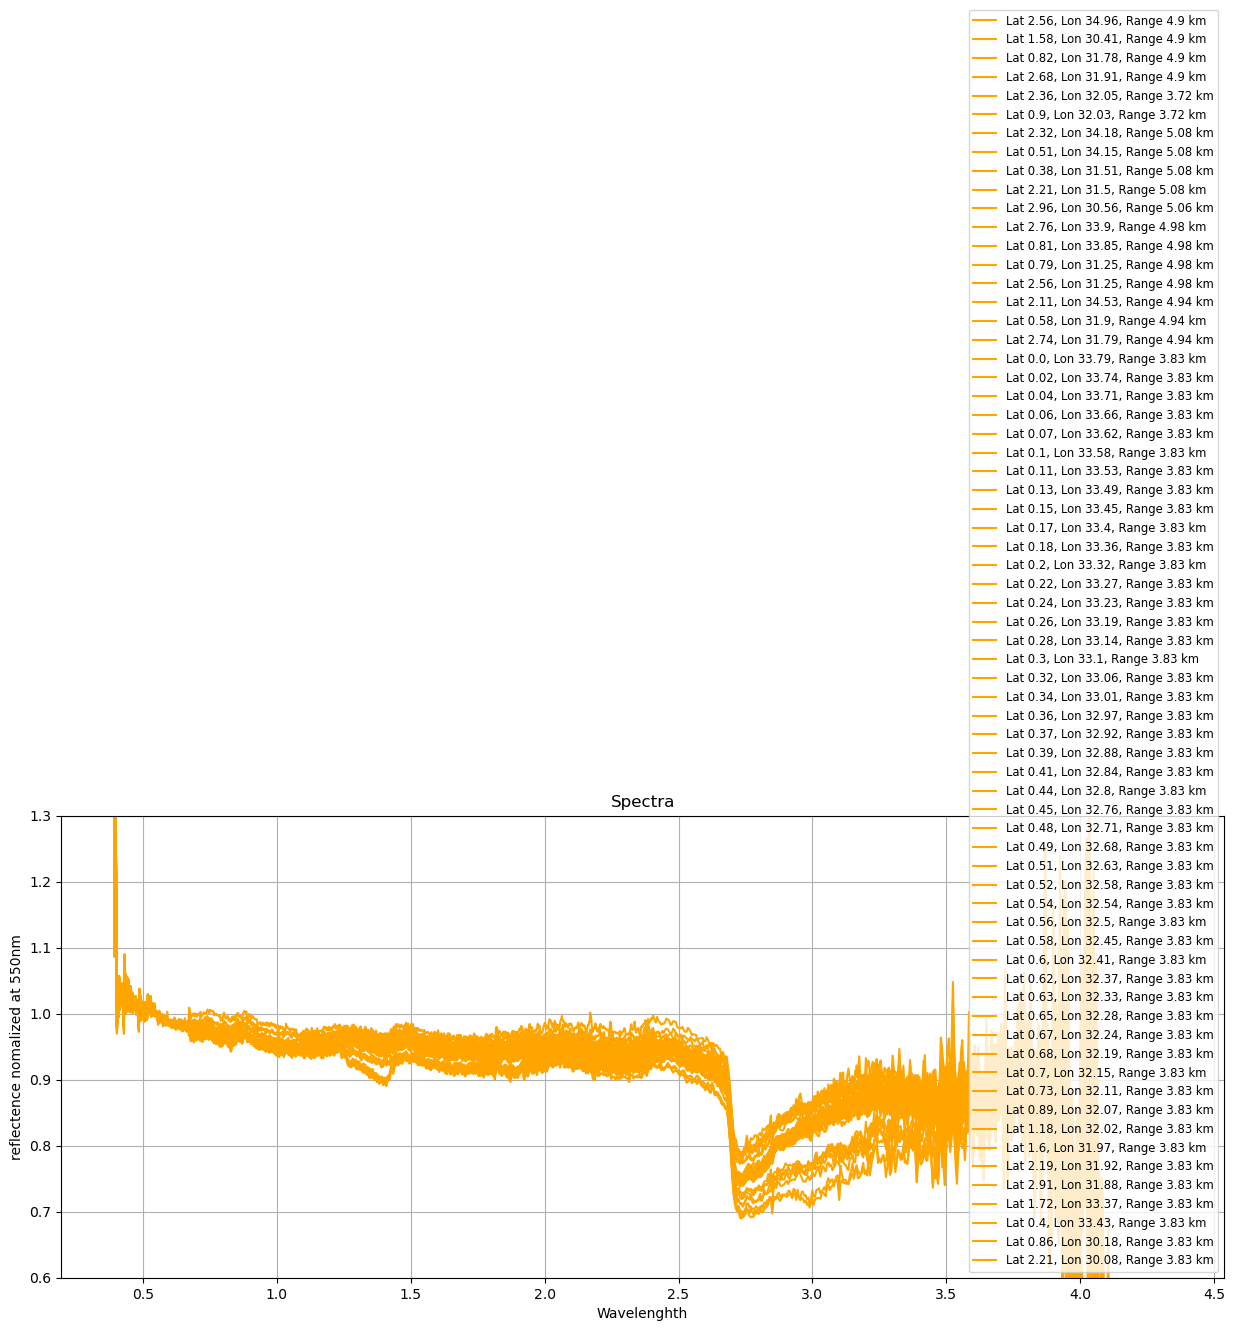

In [166]:
plot_spectra(metadata_table, spectral_data,  lat=(0, 3), lon=(30, 35))

In [123]:
print(wav)


[0.39199999 0.39399999 0.396      ... 4.32999992 4.33500004 4.34000015]


In [ ]:
#计算5度x5度 每个经纬度网格的三种距离的平均slope （wav 0.55-2.5）


In [ ]:
#Map 三个slope的分布图

#最邻近点插值 并计算slope 趋势分布






In [ ]:
#PHOTOMETRY 
